# Bi 1x 2015: Image Processing I

*This tutorial was generated from an IPython notebook.  You can download the notebook [here](image_processing_1.ipynb).*

In this tutorial, we will learn some basic techniques for image processing using [`scikit-image`](http://scikit-image.org) with Python. As with the [Introduction to Python tutorial](intro_to_python.html), do not cut and paste the commands. Type them in by hand. I intentionally have omitted all outputs in this tutorial. You will learn much more effectively that way.

As usual, we will begin by importing the modules we will use.

In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt

import skimage.io
import skimage.exposure
import skimage.filters
import skimage.morphology

# Magic function used to make this IPython notebook
%matplotlib inline

## Image processing tools for Python
There are many image processing tools available for Python. Some of them, such as ITK and OpenCV are mature image processing packages that have bindings for Python, allowing easy use of their functionality. Others were developed specifically for Python. Some of the many packages are

* [`scikit-image`](http://scikit-image.org)
* [`scipy.ndimage`](https://docs.scipy.org/doc/scipy-0.15.1/reference/ndimage.html)
* [Open CV](http://opencv.org) (extensive computer vision package)
* [Cell Profiler](http://www.cellprofiler.org) (Broad Institute at MIT)
* [Insight Segmentation and Registration Toolkit](http://www.itk.org) (ITK, used in medical imaging, supported by the NIH)
* [Fiji](http://fiji.sc) and [ImageJ](http://developer.imagej.net) support [Jython](http://www.jython.org) scripting

The first two packages are standard with Anaconda. They provide a set of basic image processing tools, with more sophisticated packages such as ITK and Fiji supplying many more bells and whistles. If in the future you have more demanding image processing requirements, the other packages can prove very useful.  

We will almost exclusively use `scikit-image` along with the standard tools from NumPy.  The package `scipy.ndimage` is quite useful, but we will use `scikit-image`, since it has expanded functionality. We will call is `skimage` for short (which is how the package is imported anyhow). A potential annoyance with `skimage` is that the main package has minimal functionality, and you must import subpackages as needed. For example, to load and view images, you will need to import `skimage.io`. Importantly, `skimage` is well-documented, and you can access the documentation at [http://scikit-image.org/](http://scikit-image.org/).

We will explore `skimage`’s capabilities and some basic image processing techniques through example. We will start with examining a graticule (stage micrometer), then put together an multi-color image, and finally analyze fluorescence and phase contrast images of growing bacteria.

##Calibrating an objective using a graticule

You should have downloaded the file [`2014-03-24_graticule.tif`](data/2014-03-24_graticule.tif).  We will use this as our graticule sample image. Note that I have given it a descriptive name. A trick I find useful is to have the first 10 characters in the file name be the date. (I often include the time as well.) That way, images you are analyzing appear in chronological order when viewed on your computer. Following the date is a descriptive title for the image. I kept the name short for the purposes of this tutorial, but for my own files, I would name the file `2014-03-24-1456_graticule_10micron_increments_10x_wheels.tif`, which specifies that I took this image at 2:56 PM on March 24, 2014 using the 10$\times$ objective on the microscope Wheels, and that the gradations on the graticule are ten microns apart. This is important to know going forward: we are calibrating a 10$\times$ objective using a graticule with 10 µm increments.

###Loading and viewing the image

We load the image using the `skimage.io.imread`.  The image is stored as a NumPy array.  Each entry in the array is a pixel value.  This is an important point: **a digital image is data**.  It is a set of numbers with spatial positions.

In [2]:
# Load images as NumPy array
grat_im = skimage.io.imread('2014-03-24_graticule.tif')

# Show that grat_im is a NumPy array
print('grat_im is', type(grat_im))

# Show that the data type is unsigned int
print('Data type is', grat_im.dtype)

# Let's look at grat_im (only works in the IPython console)
grat_im

grat_im is <type 'numpy.ndarray'>
Data type is uint8


array([[198, 201, 201, ..., 196, 195, 198],
       [200, 198, 200, ..., 197, 197, 197],
       [200, 198, 195, ..., 195, 196, 198],
       ..., 
       [199, 194, 197, ..., 193, 192, 193],
       [197, 198, 195, ..., 193, 194, 193],
       [199, 197, 197, ..., 193, 194, 194]], dtype=uint8)

An image is nothing more than a 2D array, or a matrix. Any operation we can do to a matrix, we can do to an image. That includes slicing, assignment, any mathematical operations; anything. Note also that the data type of `grat_im` is `uint8`, or unsigned 8 bit integer. This is the assumed bit depth of the image. Bit depth is the number of bits used to indicate the intensity of a single pixel in an image. For an 8-bit image, the pixel values for from $0$ to $2^8 − 1$, or from $0$ to $255$. (In general, low pixel values are dark and high pixel values are light.) skimage evaluates the pixel values in the image and then chooses which of its allowed data types are commensurate with the pixel values. skimage allows 8, 16, or 32 bit images, in addition to float images (with pixel values between 0 and 1). We will see the consequences of this later. For now, it suffices to know that our graticule image is 8 bit.

We have looked at the image as a set of numbers.  As is often the case, it is useful to "plot" data.  A common way to "plot" an image is to display it as we're used to seeing images.  We can do this with the `skimage.io.imshow` function.

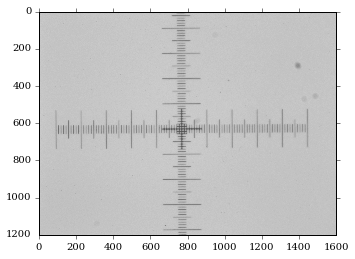

In [3]:
skimage.io.imshow(grat_im);

Finally, I note that the axes are useful to have on the plot, but we can easily get rid of them.

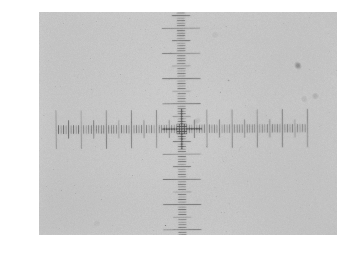

In [4]:
skimage.io.imshow(grat_im)
plt.axis('off');

###Calibration with mouse clicks

If you hover over the figure with the graticule, you should see the x-y coordinates of the cursor on the bottom of the figure window. You can memorialize these positions using `plt.ginput`.

In [ ]:
xy = plt.ginput(n=100)

The keyword argument `n` is the number of clicks to record the $x$-$y$ position of before terminating. You should specify this because the default is `n=1`. You can terminate input by pressing the enter key. `ginput` returns a list of 2-tuples. Each tuple has the $x$-$y$ coordinates of your mouse clicks. Given these two coordinates, we can compute the distance between the clicks. Remember, the units of distance in the image is pixels, so we can count gradations on the graticule to find out the physical distance between pixels.

###Calibration by plotting a line

Remember than an image is just a 2D array. We can slice a row out of the array and plot it to see the periodicity in the grid.

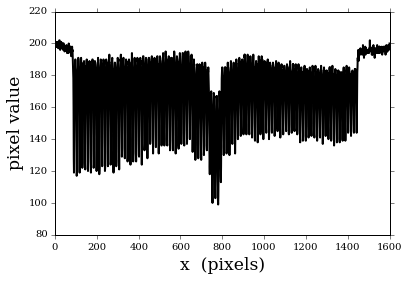

In [5]:
# Slice out a row of the image that goes through gradation marks
line_profile = grat_im[640,:]

# Plot the profile
plt.plot(line_profile, 'k-')
plt.xlabel('x  (pixels)')
plt.ylabel('pixel value')

We then have to zoom in to find the troughs and can again measure their distance by mousing over them.  We could also just plot a subset of the points across the line scan, again using slicing.

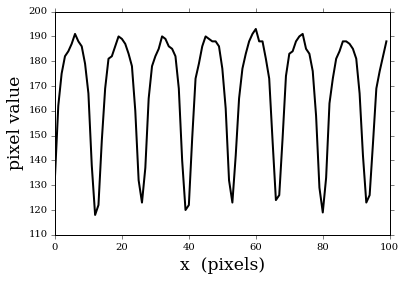

In [6]:
# Plot a portion of the line profile
plt.plot(line_profile[200:300], 'k-')
plt.xlabel('x  (pixels)')
plt.ylabel('pixel value')

##Adding a scale bar

Whenever microscope images are displayed, you must **always** indicate the scale of the image. For this purpose, scale bars are typically used. Most often, the scale bar is "burned" into the image, as opposed to overlaying a vector graphics line. This means that pixel values within the image are changed to depict a scale bar of a given length. Text is also sometimes burned into the image on top of the scale bar. I do not recommend this because low-resolution images will have badly pixelated text. Furthermore, in print publications, you can indicate the scale bar length in a figure caption. In presentations, you can simply overlay the appropriate text over the image.

Opinions vary on the best way to put a scale bar on an image. I advocate burning the scale bar, but not the text. This ensures that an rescaling of the image in presentations of publication will not alter the ratio of the scale bar to the image size. I do not advocate burning in the text, for the readability reasons I already stated.

To burn a scale bar, we can use slicing operations to get the pixels we want, and then directly change their values. For the graticule image, we might want a 100 µm scale bar in the lower right corner of the image. Since the background is white, a black scale bar will work. Based on my calculations, I calculated that the physical interpixel distance is 0.74 µm. So, for a 100 ≤m scale bar, I would want a scale bar with 100 µm / (0.74 µm / pixel) = 135 pixels.

Note: Since we are forever changing the data in our image, **never** burn a scale bar directly into an original image! Make a copy of the image. You can do this by using `np.array`.

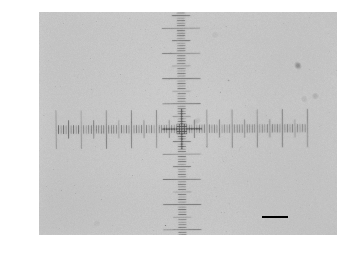

In [7]:
# Make a copy of the image
grat_im_with_scalebar = np.array(grat_im)

# Burn the scale bar by changing pixel values
grat_im_with_scalebar[1100:1110, 1200:1200+135] = 0

# Display the new image with the scalebar
skimage.io.imshow(grat_im_with_scalebar)
plt.axis('off');

###Saving the image

After adding the scale bar, we would like to save the image. `skimage.io` provides the functionality for this. Under the hood, is uses the Python Imaging Library (PIL) to write the image, but it is conveniently accessed via `skimage`.

In [8]:
# Save the image as a TIFF with descriptive title
skimage.io.imsave('2014-03-24_graticule_with_100micron_scalebar.tif', 
                  grat_im_with_scalebar)

# Save the image as a PNG
skimage.io.imsave('2014-03-24_graticule_with_100micron_scalebar.tif', 
                  grat_im_with_scalebar)

Notice that I saved the image either as a TIFF or as a PNG (`skimage.io.imsave` automatically detects the format I want from the suffix of the file name). These are **lossless** format. You should **never** save scientific data in a lossy format such as JPEG. You are literally losing data!

##Loading and viewing 12-bit images

We will now load and view the test images we will use for segmentation (described below).  You should have downloaded the images [`ecoli_phase.tif`](data/ecoli_phase.tif) and [`ecoli_cfp.tif`](data/ecoli_cfp.tif).  We'll start with an image taken using phase contrast microscopy of *E. coli*.

/Users/Justin/anaconda/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image dynamic range; displaying image with stretched contrast.
  warnings.warn("Low image dynamic range; displaying image with "


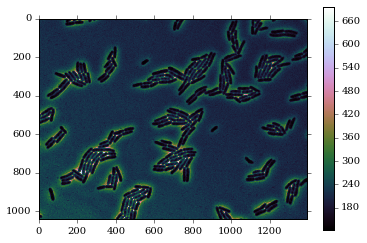

In [9]:
# Load image
im_phase = skimage.io.imread('ecoli_phase.tif')

# Display the image
skimage.io.imshow(im_phase)

We get a warning and then a strange looking picture!  The warning is that we have a low dynamic range.  We get this warning because `skimage` assumes that images with integer pixel values are either 8-bit, 16-bit, or 32-bit.  This image, as all the images we will acquired using the fluorescent microscopes in Bi 1x, were acquired with a 12-bit camera.  This means that the pixel values range from 0 to $2^{12}-1=4095$.  This is must less than what we would expect for a maximal pixel value for a 16-bit image, $2^{16}-1 = 65535$.

So, to view the images in their full range, we should divide by the maximal pixel value.

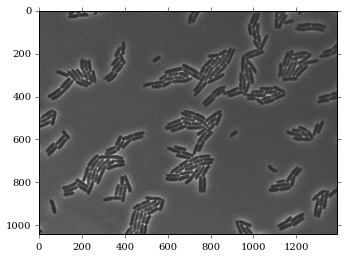

In [10]:
# Load image
im_phase = skimage.io.imread('ecoli_phase.tif')

# Display the image
skimage.io.imshow(im_phase / im_phase.max())

##Lookup tables

As an alternative to stretching the image and using `skimage.io.imshow` to view the image, we can use `matploblib`'s image viewing function, which automatically adjusts the image.  We will need to specify a `gray` colormap to look at it.  In fact, while we're at it, we can specify whatever colormap we want.

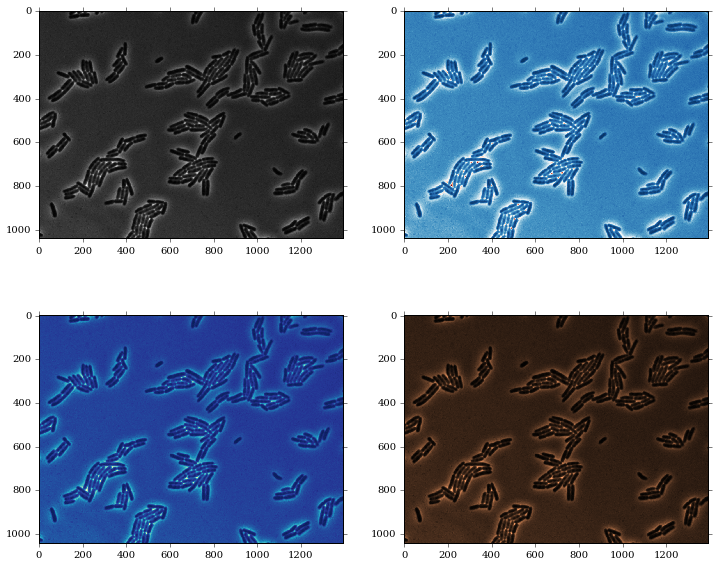

In [11]:
# Get subplots
fig, ax = plt.subplots(2, 2, figsize=(12,10))

# Display various LUTs
ax[0,0].imshow(im_phase, cmap=plt.cm.gray)
ax[0,1].imshow(im_phase, cmap=plt.cm.RdBu_r)
ax[1,0].imshow(im_phase, cmap=plt.cm.YlGnBu_r)
ax[1,1].imshow(im_phase, cmap=plt.cm.copper)

We did a few new things here.  First, we use the `plt.subplots` function to generate subplots.  Second, we used the `imshow` method of the `axes` object to display the images.   Lastly, we specified the **colormap** to be used for showing the image.  We used a grayscale colormap, `plt.cm.gray`.  This specifies how the pixel values are interpreted as they are displayed.  For a grayscale colormap, high pixel values are more white, and low pixel values are more black.

In image processing, a colormap is called a **lookup table** (LUT).  A LUT is a mapping of pixel values to a color. This sometimes helps visualize images, especially when we use false coloring.  Remember, a digital image is data, and false coloring an image if **not** manipulation of data.  It is simply a different way of plotting it.

As we just saw, we specify a lookup table with a **colormap**.  There are plenty available in `matplotlib`.  There is lots of debate about that the best colormaps (LUTs) are. The data visualization community seems to universally reject using rainbow colormaps. See, e.g., D. Borland and R. M. Taylor, Rainbow Color Map (Still) Considered Harmful, IEEE Computer Graphics and Applications, 27,14-17, 2007. In the example, I use a hue-diverging colorscale, which goes from blue to red, as people accustomed to rainbow colormaps expect, but in a perceptually ordered fashion.

Importantly, the false coloring helps use see that the intensity of the pixel values near the center of some of the bacteria are not that dissimilar from the background. This will become an issue, as we will see, when segmenting.

##Introductory segmentation

**Segmentation** is the process by which we separate regions of an image according to their identity for easier analysis. E.g., if we have an image of bacteria and we want to determine what is "bacteria" and what is "not bacteria," we would do some segmentation. We will use bacterial test images for this purpose.

###Histograms

As we begin segmentation, remember that viewing an image is just a way of plotting the digital image data.  We can also plot a **histogram**.  This helps use see some patterns in the pixel values and is often an important first step toward segmentation.

The histogram of an image is simply a list of counts of pixel values. When we plot the histogram, we can often readily see breaks in which pixel values are most frequently encountered. There are many ways of looking at histograms. I’ll show you my preferred way.

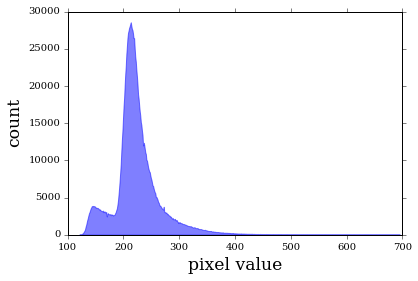

In [12]:
# Get the histogram data
hist_phase, bins_phase = skimage.exposure.histogram(im_phase)

# Use matplotlib to make a pretty plot of histogram data
plt.fill_between(bins_phase, hist_phase, alpha=0.5, color='b')

# Label axes
plt.xlabel('pixel value')
plt.ylabel('count')

We see that there are two peaks to the histogram of the phase image.  The peak to the right is brighter, so likely represents the background.  Therefore, if we can find where the valley between the two peaks is, we may take pixels with intensity below that value to be bacteria and those above to be background.  Eyeballing it, I think this critical pixel value is about 182.

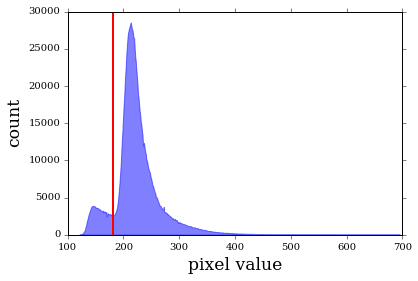

In [13]:
# Use matplotlib to make a pretty plot of histogram data
plt.fill_between(bins_phase, hist_phase, alpha=0.5, color='b')
plt.plot([182, 182], [0, 30000], 'r-')

# Label axes
plt.xlabel('pixel value')
plt.ylabel('count')

###Thresholding

The process of taking pixels above or below a certain value is called **thresholding**.  It is one of the simplest ways to segement an image.  We call every pixel with a value below 182 part of a bacterium and everything above *not* part of a bacterium.

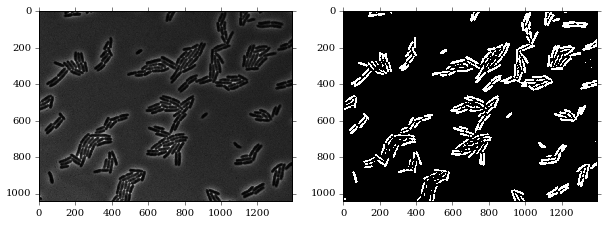

In [14]:
# Threshold value, as obtained by eye
thresh_phase = 182

# Generate thresholded image
im_phase_bw = im_phase < thresh_phase

# Display phase and thresholded image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(im_phase, cmap=plt.cm.gray)
ax[1].imshow(im_phase_bw, cmap=plt.cm.gray)

We can overlay these images to get a good view.  To do this, we will make an RGB image, and saturate the red channel where the thresholded image is white.

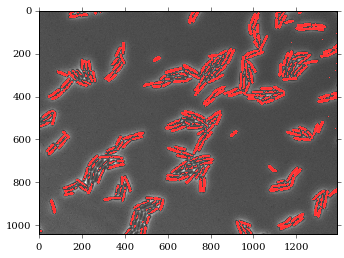

In [15]:
# Build RGB image by stacking grayscale images
im_phase_rgb = np.dstack(3 * [im_phase / im_phase.max()])

# Saturate red channel wherever there are white pixels in thresh image
im_phase_rgb[im_phase_bw, 0] = 1.0

# Show thr result
plt.imshow(im_phase_rgb)

We see that we did a decent job finding bacteria, but we do not effectively label the bacteria in the middle of colonies.  This is because of the "halo" of high intensity signal near boundaries of the bacteria that we get from using phase contrast microscopy. 

###Using the CFP channel

One way around this issue is to use bacteria that constitutively express a fluoresent protein and to segement in using the fluorescent channel.  Let's try the same procedure with the CFP channel.  First, let's look at the image.

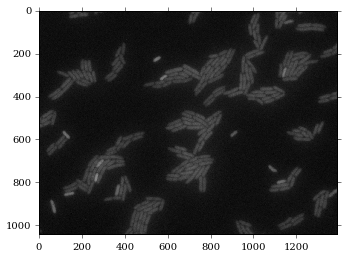

In [16]:
# Load image
im_cfp = skimage.io.imread('ecoli_cfp.tif')

# Display the image
plt.imshow(im_cfp, cmap=plt.cm.gray)

We can also look with a different LUT.

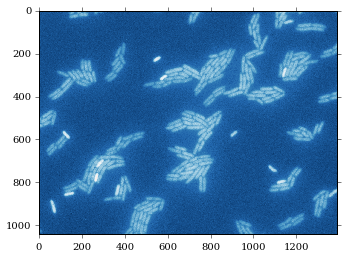

In [17]:
# Display the image with red-blue color map
plt.imshow(im_cfp, cmap=plt.cm.RdBu_r)

We see that the bacteria are typically brighter than the background, so this might help us in segmentation.

###Filtering noise: the median filter

It is strange that there do not appear to be any red (indicating high intensity) pixels in the display of the CFP image with the red-blue LUT.  This is because there are some "bad" pixels in the image, resulting from noise or some other error in the detector.  We can see this if we zoom in on one of the bad pixels.

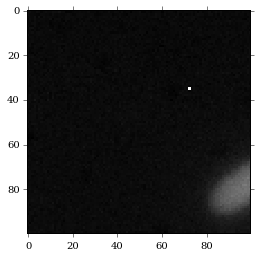

In [18]:
plt.imshow(im_cfp[150:250,450:550] / im_cfp.max(), cmap=plt.cm.gray)

We see a single bright pixel. This will throw off our color map.  We can remove this noise by using a **median filter**.  The concept is simple. We take a shape of pixels, called a **structuring element**, and pass it over the image. The value of the center pixel in the max is replaced by the median value of all pixels in the mask. To do this, we first need to construct a mask. This is done using the `skimage.morphology` module. The filtering is then done using `skimage.filter.rank.median`. Let’s try it with a 3$\times$3 square mask.

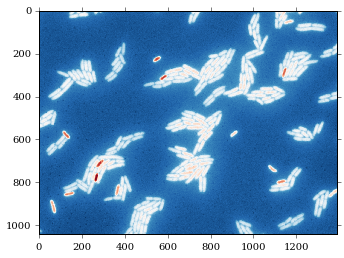

In [19]:
# Make the structuring element
selem = skimage.morphology.square(3)

# Perform the median filter
im_cfp_filt = skimage.filters.median(im_cfp, selem)

# Show filtered image with red-blue LUT
plt.imshow(im_cfp_filt, cmap=plt.cm.RdBu_r)

Now that we have dealt with the noisy pixels, we can now see more clearly that some cells are very bright (shown in red) compared with others.  We also have an image that makes more sense; we have eliminated the noise.

###Thresholding in the CFP channel

We'll proceed by plotting the histogram and finding the threshold value.  Eyeballing it, I get a threshold value of 198.

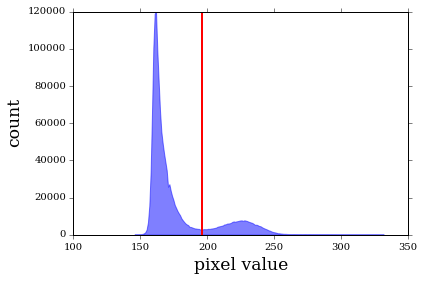

In [20]:
# Get the histogram data
hist_cfp, bins_cfp = skimage.exposure.histogram(im_cfp_filt)

# Use matplotlib to make a pretty plot of histogram data
plt.fill_between(bins_cfp, hist_cfp, alpha=0.5, color='b')
plt.plot([196, 196], [0, 120000], 'r-')

# Label axes
plt.xlabel('pixel value')
plt.ylabel('count')

Now let's try thresholding this image.

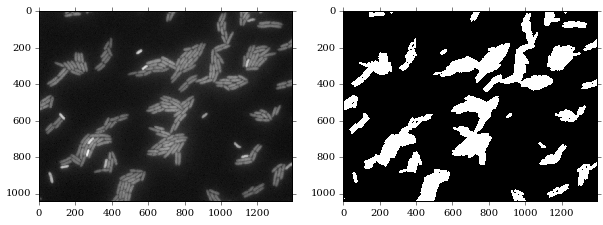

In [31]:
# Threshold value, as obtained by eye
thresh_cfp = 196

# Generate thresholded image
im_cfp_bw = im_cfp_filt > thresh_cfp

# Display phase and thresholded image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(im_cfp_filt, cmap=plt.cm.gray)
ax[1].imshow(im_cfp_bw, cmap=plt.cm.gray)

Looks like we're doing much better!  Let's try overlapping the images now.

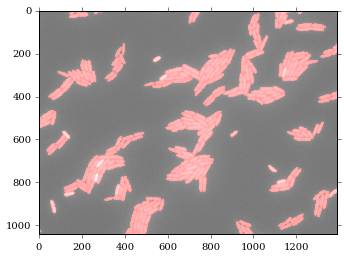

In [29]:
# Build RGB image by stacking grayscale images
im_cfp_rgb = np.dstack(3 * [im_cfp_filt / im_cfp_filt.max()])

# Saturate red channel wherever there are white pixels in thresh image
im_cfp_rgb[im_cfp_bw, 0] = 1.0

# Show the result
plt.imshow(im_cfp_rgb)

Much better, though we see that we overcount the spaces between bacteria.

###Otsu's method for thresholding

It turns out that there is an automated way to find the threshold value, as opposed to eyeballing it like we have been doing.  Otsu's method provides this functionality.

In [23]:
# Compute Otsu thresholds for phase and cfp
thresh_phase_otsu = skimage.filters.threshold_otsu(im_phase)
thresh_cfp_otsu = skimage.filters.threshold_otsu(im_cfp_filt)

# Compare results to eyeballing it
print('Phase by eye: ', thresh_phase, '   CFP by eye: ', thresh_cfp)
print('Phase by Otsu:', thresh_phase_otsu,   
      '   CFP by Otsu:', thresh_cfp_otsu)

Phase by eye:  182    CFP by eye:  196
Phase by Otsu: 248    CFP by Otsu: 195


We see that for the CFP channel, the Otsu method did very well.  However, for phase, we see a big difference.  This is because the Otsu method assumes a bimodal distribution of pixels.  If we look at the histograms on a log scale, we see more clearly that the phase image has a long tail, which will trip up the Otsu algorithm.  The moral of the story is that you can use automated thresholding, but you should always do sanity checks to make sure it is working as expected.

/Users/Justin/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from IPython.kernel.zmq import kernelapp as app
/Users/Justin/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


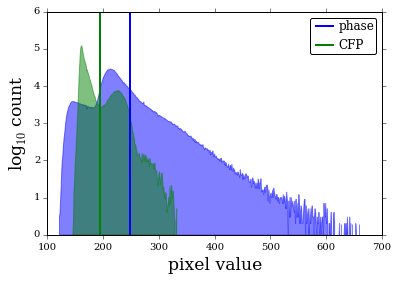

In [24]:
# Plot the histograms together.
plt.fill_between(bins_phase, np.log10(hist_phase), alpha=0.5, color='b')
plt.fill_between(bins_cfp, np.log10(hist_cfp), alpha=0.5, color='g')
plt.plot([thresh_phase_otsu, thresh_phase_otsu], [0, 6], 'b-')
plt.plot([thresh_cfp_otsu, thresh_cfp_otsu], [0, 6], 'g-')
plt.legend(('phase', 'CFP'), loc='upper right')

# Label axes
plt.xlabel('pixel value')
plt.ylabel('log$_{10}$ count')

##Determining the bacterial area

Now that we have a thresholded image, we can determine the total area taken up by bacteria.  It's as simple as summing up the pixel values of the thresholded image!

In [25]:
# Compute bacterial area
bacterial_area_pix = im_cfp_bw.sum()

# Print out the result
print('bacterial area =', bacterial_area_pix, 'pixels')

bacterial area = 264447 pixels


For growth curves, we really only need the pixel values, since we are trying to get a time constant, which is independent of the unit of measure for bacterial numbers.  Nonetheless, if we want to get the total area that is bacterial in units of µm, we could use the interpixel distances to get the area represented by each pixel.  For this setup, the interpixel distance is 0.0636 µm.  We can then compute the bacterial area as follows.

In [26]:
# Define interpixel distance
interpix_dist = 0.0636 # microns

# Compute bacterial area
bacterial_area_micron = bacterial_area_pix * interpix_dist**2

# Print total area
print('bacterial area =', bacterial_area_micron, 'square microns')

bacterial area = 1069.67753712 square microns
